This notebook is meant for trying out stuff, which might later be put to other notebooks or python scripts.

In [1]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from api.GlassnodeAPI import GlassnodeAPI
from api.CoinGeckoAPI import CoinGeckoAPI
from functions.functions import *
from visualization.line_graph import *
from visualization.comparisons import *
from functions.impermanent_loss import *

In [2]:
g = GlassnodeAPI(open("/home/malimi/Skillset/glassnode_api_key.txt",'r').read()[:-1])
g.get_new_addresses_and_price(period='week')

,time,price,number of new addresses
0,2010-07-18 02:00:00,0.085840,15296
1,2010-07-25 02:00:00,0.050500,5169
2,2010-08-01 02:00:00,0.061100,2773
3,2010-08-08 02:00:00,0.060900,3162
4,2010-08-15 02:00:00,0.065290,2880
...,...,...,...
600,2022-01-16 01:00:00,43122.787414,2916918
601,2022-01-23 01:00:00,36254.879857,2845409
602,2022-01-30 01:00:00,37936.328777,2787253
603,2022-02-06 01:00:00,42411.104290,2846328


In [3]:
g = GlassnodeAPI(open("/home/malimi/Skillset/glassnode_api_key.txt",'r').read()[:-1])
g.get_new_addresses_and_price()

,time,price,number of new addresses
0,2010-07-17 02:00:00,0.049510,447
1,2010-07-18 02:00:00,0.085840,467
2,2010-07-19 02:00:00,0.080800,605
3,2010-07-20 02:00:00,0.074733,674
4,2010-07-21 02:00:00,0.079210,469
...,...,...,...
4229,2022-02-13 01:00:00,42242.100147,380063
4230,2022-02-14 01:00:00,42601.715072,395754
4231,2022-02-15 01:00:00,44600.784174,429282
4232,2022-02-16 01:00:00,43980.514559,435357


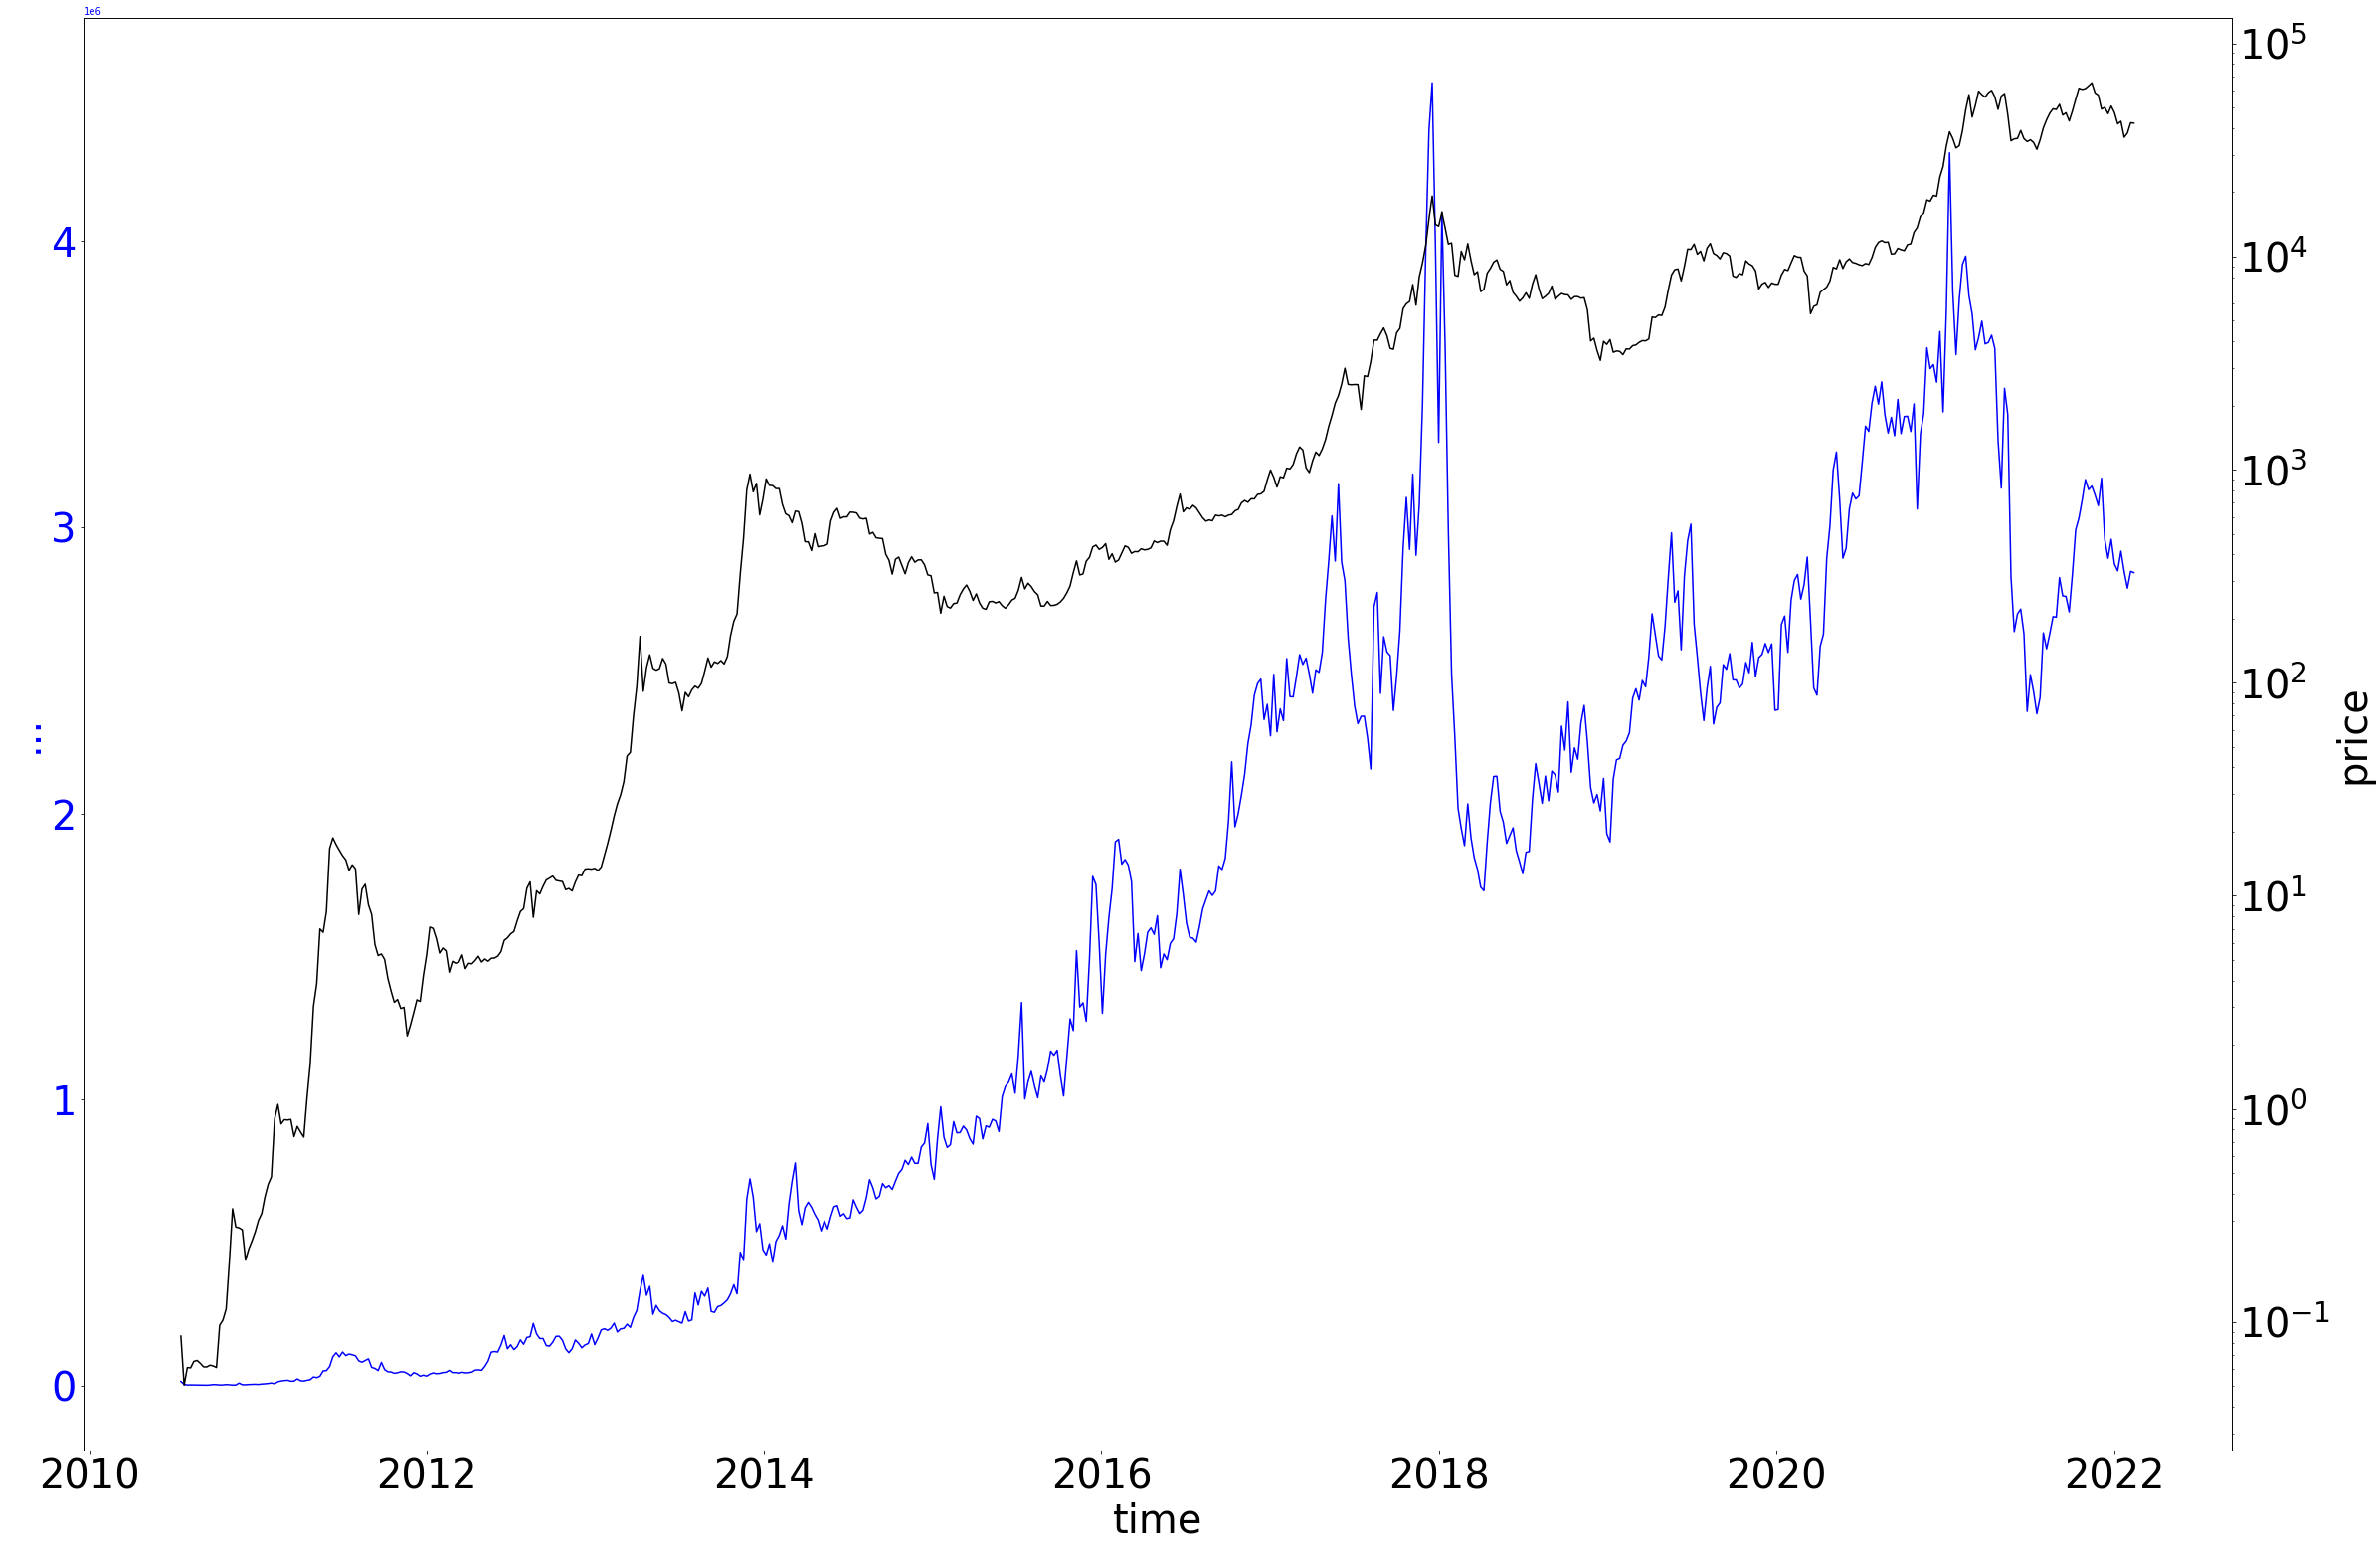

In [4]:
df = g.get_new_addresses_and_price(period='week')
fig, ax1, ax2 = with_price_in_background(df['time'],df['price'])
ax1.set_ylabel(f'...',color='blue', fontsize=40)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=40)
ax1.plot(df['time'],df['number of new addresses'],color='blue')
plt.show()

In [5]:
coin_list = ['bitcoin', 'ethereum', 'fantom', 'solana', 'polkadot', 'the-sandbox', 'kusama', 'decentraland']
c = CoinGeckoAPI()

In [6]:
end = datetime.now()
start = datetime(end.year-1, end.month, end.day)

In [7]:
for coin in coin_list:
    globals()[coin] = c.get_price_cap_volume(start, end, coin=coin)

In [8]:
closing_df = pd.DataFrame()
for coin in coin_list:
    closing_df[coin] = globals()[coin]['price']
rets = closing_df.pct_change()

In [9]:
days = 365
dt = 1/days
coin = 'bitcoin'
mu = rets.mean()[coin]
sigma = rets.std()[coin]
def monte_carlo(start_price,days,mu,sigma):
    price = np.zeros(days)
    price[0] = start_price
    shock = np.zeros(days)
    drift = np.zeros(days)
    for x in range(1,days):
        shock[x] = np.random.normal(loc=mu*dt, scale=sigma*np.sqrt(dt))
        drift[x] = mu*dt
        price[x] = price[x-1] + (price[x-1]*(drift[x]+shock[x]))
    return price

Text(0.5, 1.0, 'monte carlo analysis')

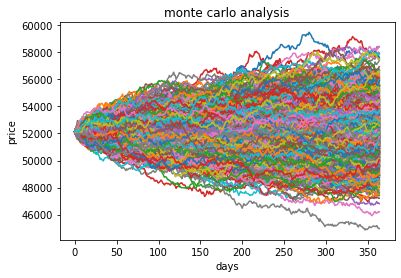

In [10]:
start_price = closing_df[coin][0]
for run in range(1000):
    plt.plot(monte_carlo(start_price,days,mu,sigma))
plt.xlabel('days')
plt.ylabel('price')
plt.title('monte carlo analysis')

In [11]:
runs = 10000
simulations = np.zeros(runs)
for run in range(runs):
    simulations[run] = monte_carlo(start_price,days,mu,sigma)[days-1]

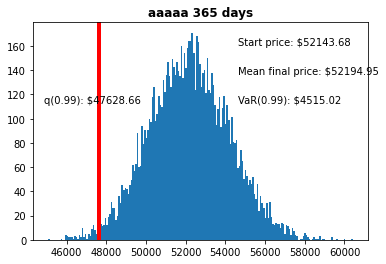

In [12]:
q = np.percentile(simulations,1)
plt.hist(simulations,bins=200)
# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - q,))

# Display 1% quantile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title(u"aaaaa %s days" % days, weight='bold');
